In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from auxFunctions import *

In [2]:
plt.rcParams['figure.figsize']=[8,8]
%config InlineBackend.figure_format = 'retina'

# Set the antibody before running the notebook!

In [83]:
antibody = "H3K27ac"

In [84]:
ab_dict = {"H3K4me3":"MK01_H3K4me3", "H3K27ac":"MK02_H3K27ac"}

os.chdir("/Users/mukkab/Downloads/ArchR/scCT/scripts")

## Barcode Filtering

### Read in the barcode statistics files

In [85]:
all_barcode_files = stripReformat("../barcode_statistics/{}/all_barcodes.txt".format(ab_dict[antibody]))
peak_barcodes_file = stripReformat("../barcode_statistics/{}/peaks_barcodes_broad.txt".format(ab_dict[antibody]))
metadata_file = "../CT_fragments/{}-singlecell.csv".format(ab_dict[antibody])

In [86]:
## testing with SEACR

all_barcode_files = stripReformat("../barcode_statistics/{}/all_barcodes.txt".format(ab_dict[antibody]))
peak_barcodes_file = stripReformat("../barcode_statistics/barcode_statistics_SEACR/{}_barcodes_SEACR.txt".format(ab_dict[antibody]))
metadata_file = "../CT_fragments/{}-singlecell.csv".format(ab_dict[antibody])


In [87]:
all_barcodes = pd.read_csv(all_barcode_files, sep="\t", header=None, index_col=False, names=["all_unique_CT", "barcode"])
peak_barcodes = pd.read_csv(peak_barcodes_file, sep="\t", header=None, index_col=False, names=["peak_CT","barcode"])
metadata = pd.read_csv(metadata_file, sep=",", header=0)

In [88]:
if "NO_BARCODE" in metadata.barcode.values:
    metadata = metadata[metadata.barcode != "NO_BARCODE"]
    
metadata["logUMI"] = np.log10(metadata.passed_filters + 1)
metadata["promoter_ratio_10x"] = (metadata.promoter_region_fragments + 1)/(metadata.passed_filters + 1)
metadata["peak_region_ratio_10x"] = (metadata.peak_region_fragments + 1)/(metadata.passed_filters + 1)

In [89]:
bcd = pd.merge(peak_barcodes, all_barcodes)[["barcode", "all_unique_CT", "peak_CT"]]
bcd["peak_ratio_CT"] = bcd.peak_CT / bcd.all_unique_CT

metadata = pd.merge(metadata, bcd)
metadata["passed_CT"] = "False" 

### Set thresholds for filtering

In [90]:
cutoff_reads_min = 10**3
cutoff_read_max = 10**5

if antibody == "H3K27ac":
    cutoff_peak_percentage_low = 0.2
    cutoff_peak_percentage_medium = 0.5
    cutoff_peak_percentage_high = 0.8
elif antibody == "H3K4me3":
    cutoff_peak_percentage_low = 0.2
    cutoff_peak_percentage_high = 0.98

In [91]:
metadata.loc[(metadata.all_unique_CT > cutoff_reads_min) & 
    (metadata.all_unique_CT < cutoff_read_max) &
    (metadata.peak_ratio_CT > cutoff_peak_percentage_medium) &
    (metadata.peak_ratio_CT < cutoff_peak_percentage_high), "passed_CT"] = "High"

metadata.loc[(metadata.all_unique_CT > cutoff_reads_min) & 
    (metadata.all_unique_CT < cutoff_read_max) &
    (metadata.peak_ratio_CT > cutoff_peak_percentage_low) &
    (metadata.peak_ratio_CT < cutoff_peak_percentage_medium), "passed_CT"] = "Low"

In [72]:
metadata.loc[(metadata.all_unique_CT > cutoff_reads_min) & 
    (metadata.all_unique_CT < cutoff_read_max) &
    (metadata.peak_ratio_CT > cutoff_peak_percentage_low) &
    (metadata.peak_ratio_CT < cutoff_peak_percentage_high), "passed_CT"] = True

### Plot scatterplot of filtered cells

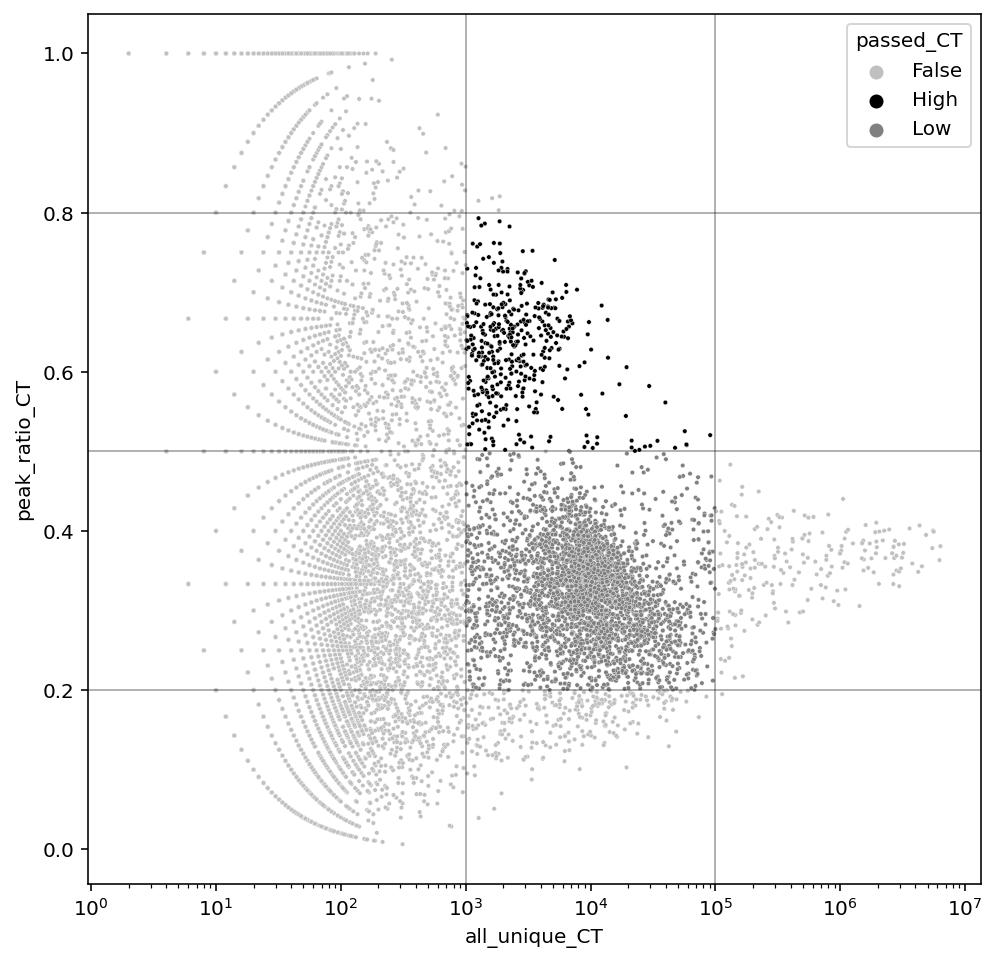

In [97]:
cell_plot = sns.scatterplot(data=metadata, x="all_unique_CT", y="peak_ratio_CT", 
                            hue="passed_CT", palette=["silver", "black", "grey"], s=5)
cell_plot.set(xscale="log")
plt.axhline(y = cutoff_peak_percentage_low, color='black', linewidth=1, alpha=.3)
plt.axhline(y = cutoff_peak_percentage_medium, color='black', linewidth=1, alpha=.3)
plt.axhline(y = cutoff_peak_percentage_high, color='black', linewidth=1, alpha=.3)
plt.axvline(x = cutoff_reads_min, color='black', linewidth=1, alpha=.3)
plt.axvline(x = cutoff_read_max, color='black', linewidth=1, alpha=.3)

In [101]:
len(metadata[metadata.passed_CT=="Low"])

3208

### Filter the metadata and the fragments file

In [65]:
passed_CT = metadata[metadata.passed_CT==True]
filtered_barcode_list = passed_CT.barcode.values.tolist()

In [66]:
len(passed_CT.index)

3996

In [68]:
len(filtered_barcode_list)

3996

In [32]:
%%time
filterFragments(barcodelist=filtered_barcode_list, 
                fragments="../CT_fragments/{}.fragments.tsv.gz".format(ab_dict[antibody]), 
                out_gz="../CT_fragments/{}_SEACR_FILTERED.fragments.tsv".format(ab_dict[antibody]))

CPU times: user 30min 3s, sys: 2.71 s, total: 30min 6s
Wall time: 30min 8s


Run preArchR.sh from scripts/ before running generating ArrowFiles in ArchR


## Now run ArchR using the filtered Fragments